# Installing libraries

In [1]:
!pip install aif360
!pip install fairlearn
!pip install BlackBoxAuditing
!pip install adversarial-robustness-toolbox 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 41.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394756 sha256=6f90ab6493999350e55d02eb68d880238b6a4f8a1b56f51797d4223e7b28dac4
  Stored in directory: /root/.cache/pip/wheels/c0/4f/b1/80e1b0790df07536470758fe0a4f9ff8fa942fd9fe30bbb192
Successfully built BlackBoxAuditing
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.2 MB/s eta 0:00:00


# Class Definitions

In [2]:
"""
The code for ExponentiatedGradientReduction wraps the source class
fairlearn.reductions.ExponentiatedGradient
available in the https://github.com/fairlearn/fairlearn library
licensed under the MIT Licencse, Copyright Microsoft Corporation
"""
import fairlearn.reductions as red
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder


class ExponentiatedGradientReduction(BaseEstimator, ClassifierMixin):
    """Exponentiated gradient reduction for fair classification.

    Exponentiated gradient reduction is an in-processing technique that reduces
    fair classification to a sequence of cost-sensitive classification problems,
    returning a randomized classifier with the lowest empirical error subject to
    fair classification constraints [#agarwal18]_.

    References:
        .. [#agarwal18] `A. Agarwal, A. Beygelzimer, M. Dudik, J. Langford, and
           H. Wallach, "A Reductions Approach to Fair Classification,"
           International Conference on Machine Learning, 2018.
           <https://arxiv.org/abs/1803.02453>`_
    """
    def __init__(self,
                 prot_attr,
                 estimator,
                 constraints,
                 eps=0.01,
                 max_iter=50,
                 nu=None,
                 eta0=2.0,
                 run_linprog_step=True,
                 drop_prot_attr=True):
        """
        Args:
            prot_attr: String or array-like column indices or column names of
                protected attributes.
            estimator: An estimator implementing methods
                ``fit(X, y, sample_weight)`` and ``predict(X)``, where ``X`` is
                the matrix of features, ``y`` is the vector of labels, and
                ``sample_weight`` is a vector of weights; labels ``y`` and
                predictions returned by ``predict(X)`` are either 0 or 1 -- e.g.
                scikit-learn classifiers.
            constraints (str or fairlearn.reductions.Moment): If string, keyword
                denoting the :class:`fairlearn.reductions.Moment` object
                defining the disparity constraints -- e.g., "DemographicParity"
                or "EqualizedOdds". For a full list of possible options see
                `self.model.moments`. Otherwise, provide the desired
                :class:`~fairlearn.reductions.Moment` object defining the
                disparity constraints.
            eps: Allowed fairness constraint violation; the solution is
                guaranteed to have the error within ``2*best_gap`` of the best
                error under constraint eps; the constraint violation is at most
                ``2*(eps+best_gap)``.
            max_iter: Maximum number of iterations.
            nu: Convergence threshold for the duality gap, corresponding to a
                conservative automatic setting based on the statistical
                uncertainty in measuring classification error.
            eta0: Initial setting of the learning rate.
            run_linprog_step: If True each step of exponentiated gradient is
                followed by the saddle point optimization over the convex hull
                of classifiers returned so far.
            drop_prot_attr: Boolean flag indicating whether to drop protected
                attributes from training data.
        """
        self.prot_attr = prot_attr
        self.estimator = estimator
        self.constraints = constraints
        self.eps = eps
        self.max_iter = max_iter
        self.nu = nu
        self.eta0 = eta0
        self.run_linprog_step = run_linprog_step
        self.drop_prot_attr = drop_prot_attr

    def fit(self, X, y):
        """Learns randomized model with less bias

        Args:
            X (pandas.DataFrame): Training samples.
            y (array-like): Training labels.

        Returns:
            self
        """
        self.estimator_ = clone(self.estimator)

        moments = {
            "DemographicParity": red.DemographicParity,
            "EqualizedOdds": red.EqualizedOdds,
            "TruePositiveRateParity": red.TruePositiveRateParity,
            "FalsePositiveRateParity": red.FalsePositiveRateParity,
            "ErrorRateParity": red.ErrorRateParity,
        }
        if isinstance(self.constraints, str):
            if self.constraints not in moments:
                raise ValueError(f"Constraint not recognized: {self.constraints}")
            self.moment_ = moments[self.constraints]()
        elif isinstance(self.constraints, red.Moment):
            self.moment_ = self.constraints
        else:
            raise ValueError("constraints must be a string or Moment object.")

        self.model_ = red.ExponentiatedGradient(self.estimator_, self.moment_,
                eps=self.eps, max_iter=self.max_iter, nu=self.nu, eta0=self.eta0)

        A = X[self.prot_attr]

        if self.drop_prot_attr:
            X = X.drop(self.prot_attr, axis=1)

        le = LabelEncoder()
        y = le.fit_transform(y)
        self.classes_ = le.classes_

        self.model_.fit(X, y, sensitive_features=A)

        return self


    def predict(self, X):
        """Predict class labels for the given samples.
        Args:
            X (pandas.DataFrame): Test samples.
        Returns:
            numpy.ndarray: Predicted class label per sample.
        """
        if self.drop_prot_attr:
            X = X.drop(self.prot_attr, axis=1)

        return self.classes_[self.model_.predict(X)]


    def predict_proba(self, X):
        """Probability estimates.

        The returned estimates for all classes are ordered by the label of
        classes.

        Args:
            X (pandas.DataFrame): Test samples.

        Returns:
            numpy.ndarray: Returns the probability of the sample for each class
            in the model, where classes are ordered as they are in
            ``self.classes_``.
        """
        if self.drop_prot_attr:
            X = X.drop(self.prot_attr, axis=1)

        return self.model_._pmf_predict(X)

# Pre-processing steps

In [3]:
import pandas as pd
import numpy as np
data = pd.read_csv('/kaggle/input/case-combined/merged_subjects_data.csv')
data

,time,valence,arousal,video_x,Emotion,ecg,bvp,gsr,rsp,skt,emg_zygo,emg_coru,emg_trap,video_y,SUBJECT,AGE,GENDER,EMOTION,video_name,vid_emotion
0,1061504,-1276.0,6252.0,8.0,Frustrated or Impatient,0.76062,35.053549,4.384464,27.174558,28.863552,7.86300,6.13825,5.31675,8.0,1,30-34,F,scary,Mama (2008),scary-2
1,1061554,-1276.0,6252.0,8.0,Frustrated or Impatient,0.79018,35.005141,4.360800,27.193884,28.849530,7.94525,5.76850,5.15250,8.0,1,30-34,F,scary,Mama (2008),scary-2
2,1061604,-1276.0,6268.0,8.0,Frustrated or Impatient,0.80990,35.809029,4.380504,27.213270,28.860030,8.06850,5.72750,5.02950,8.0,1,30-34,F,scary,Mama (2008),scary-2
3,1061654,-1276.0,6268.0,8.0,Frustrated or Impatient,0.83946,37.368456,4.384464,27.281031,28.863552,7.37025,6.09725,5.31675,8.0,1,30-34,F,scary,Mama (2008),scary-2
4,1061704,-1276.0,6288.0,8.0,Frustrated or Impatient,0.79018,37.145698,4.356864,27.271309,28.863552,7.65775,5.89175,5.11150,8.0,1,30-34,F,scary,Mama (2008),scary-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196278,2231442,0.0,0.0,7.0,Neutral,1.05632,37.949645,37.403472,46.155954,29.852173,5.39900,7.53450,5.89175,7.0,29,25-29,M,scary,Shutter (2004),scary-1
196279,2231492,0.0,0.0,7.0,Neutral,0.81318,37.542807,37.419240,46.223715,29.852173,5.64550,7.98625,5.85075,7.0,29,25-29,M,scary,Shutter (2004),scary-1
196280,2231542,0.0,0.0,7.0,Neutral,0.82632,36.961677,37.320672,46.301140,29.845152,5.56325,7.41125,5.72750,7.0,29,25-29,M,scary,Shutter (2004),scary-1
196281,2231592,0.0,0.0,7.0,Neutral,0.83290,36.516101,37.407408,46.397951,29.862694,5.76850,7.57550,5.80975,12.0,29,25-29,M,scary,Shutter (2004),scary-1


In [4]:
data['Emotion'].unique()

array(['Frustrated or Impatient', 'Tensed or Annoyed',
       'Distressed or Defiant', 'Neutral', 'Confident or Attentive',
       'Passionate or Amused', 'Pleased or Glad', 'Delighted or Happy',
       'Worried or Apathetic', 'Frustrated or Discontented',
       'Aroused or Astonished', 'Miserable or Sad', 'Anxious or Dejected',
       'Tired or Bored', 'Polite or Sleepy', 'Excited or Adventurous'],
      dtype=object)

In [5]:
# Define positive and negative emotions
positive_emotions = [
    'Confident or Attentive', 'Passionate or Amused', 'Pleased or Glad', 
    'Delighted or Happy', 'Excited or Adventurous', 'Polite or Sleepy', 
    'Neutral', 'Aroused or Astonished'
]

# Add a new column 'Emotion_Type' to classify emotions as Positive or Negative
data['Emotion_Type'] = data['Emotion'].apply(
    lambda x: 'Positive' if x in positive_emotions else 'Negative'
)
# Define the columns to retain
columns_to_keep = [
    'ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_coru', 'emg_trap', 'emg_zygo',  # 8 physio features
    'Emotion', 'AGE', 'GENDER', 'Emotion_Type'  # Other required columns
]

# Create a new DataFrame retaining only the specified columns
data = data[columns_to_keep]

In [6]:
data

,ecg,bvp,gsr,rsp,skt,emg_coru,emg_trap,emg_zygo,Emotion,AGE,GENDER,Emotion_Type
0,0.76062,35.053549,4.384464,27.174558,28.863552,6.13825,5.31675,7.86300,Frustrated or Impatient,30-34,F,Negative
1,0.79018,35.005141,4.360800,27.193884,28.849530,5.76850,5.15250,7.94525,Frustrated or Impatient,30-34,F,Negative
2,0.80990,35.809029,4.380504,27.213270,28.860030,5.72750,5.02950,8.06850,Frustrated or Impatient,30-34,F,Negative
3,0.83946,37.368456,4.384464,27.281031,28.863552,6.09725,5.31675,7.37025,Frustrated or Impatient,30-34,F,Negative
4,0.79018,37.145698,4.356864,27.271309,28.863552,5.89175,5.11150,7.65775,Frustrated or Impatient,30-34,F,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...
196278,1.05632,37.949645,37.403472,46.155954,29.852173,7.53450,5.89175,5.39900,Neutral,25-29,M,Positive
196279,0.81318,37.542807,37.419240,46.223715,29.852173,7.98625,5.85075,5.64550,Neutral,25-29,M,Positive
196280,0.82632,36.961677,37.320672,46.301140,29.845152,7.41125,5.72750,5.56325,Neutral,25-29,M,Positive
196281,0.83290,36.516101,37.407408,46.397951,29.862694,7.57550,5.80975,5.76850,Neutral,25-29,M,Positive


Gender and Age Distribution (Heatmap Data):
AGE     20-24  25-29  30-34  35-39
GENDER                            
F       47654  32822  13625      0
M       20440  61304   6812  13626
Total Instances: 196283


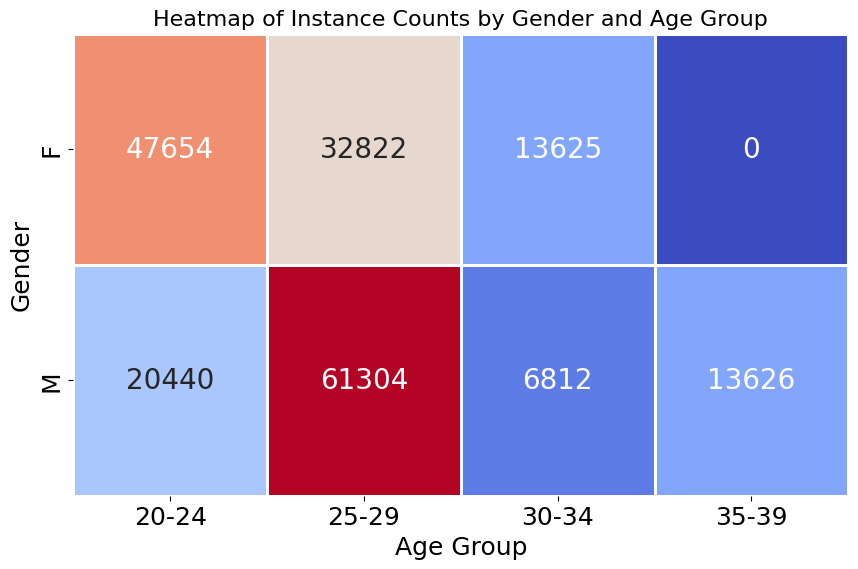


Emotion Type Counts and Percentages:
Emotion
Neutral                       108843
Confident or Attentive         18418
Passionate or Amused           17212
Frustrated or Impatient        16325
Distressed or Defiant          11175
Worried or Apathetic            6601
Tensed or Annoyed               4845
Delighted or Happy              4296
Pleased or Glad                 2963
Frustrated or Discontented      1823
Tired or Bored                  1195
Aroused or Astonished           1152
Polite or Sleepy                 982
Miserable or Sad                 247
Anxious or Dejected              157
Excited or Adventurous            49
Name: count, dtype: int64
Emotion
Neutral                       55.452077
Confident or Attentive         9.383390
Passionate or Amused           8.768971
Frustrated or Impatient        8.317073
Distressed or Defiant          5.693310
Worried or Apathetic           3.363001
Tensed or Annoyed              2.468375
Delighted or Happy             2.188677
Pleased 

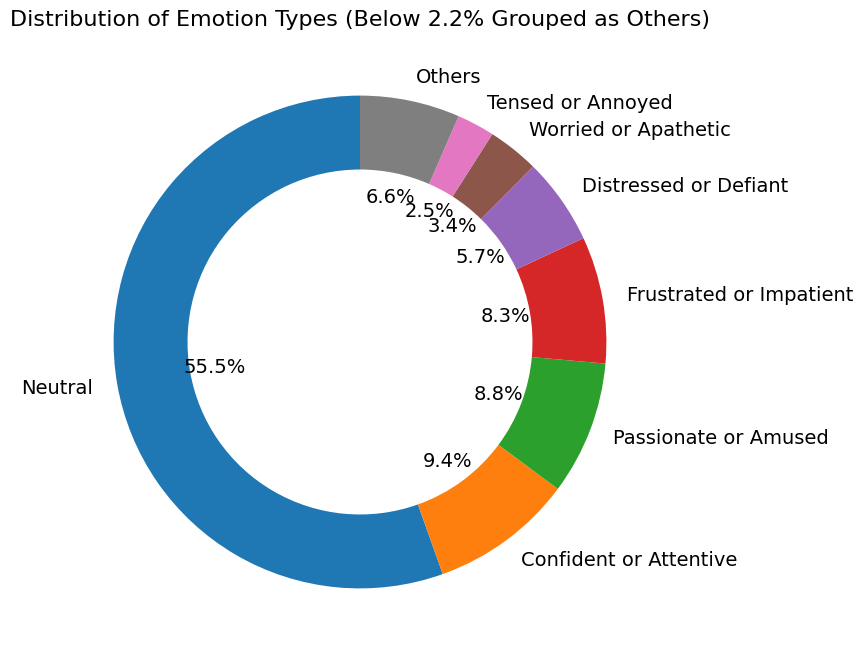


Number of Instances with 'Neutral': 108843

Emotion Type Counts (Excluding Neutral):
Emotion
Confident or Attentive        18418
Passionate or Amused          17212
Frustrated or Impatient       16325
Distressed or Defiant         11175
Worried or Apathetic           6601
Tensed or Annoyed              4845
Delighted or Happy             4296
Pleased or Glad                2963
Frustrated or Discontented     1823
Tired or Bored                 1195
Aroused or Astonished          1152
Polite or Sleepy                982
Miserable or Sad                247
Anxious or Dejected             157
Excited or Adventurous           49
Name: count, dtype: int64
Total Instances (Excluding Neutral): 87440
Emotion Type Percentages (Excluding Neutral):
Emotion
Confident or Attentive        21.063586
Passionate or Amused          19.684355
Frustrated or Impatient       18.669945
Distressed or Defiant         12.780192
Worried or Apathetic           7.549177
Tensed or Annoyed              5.540942
Del

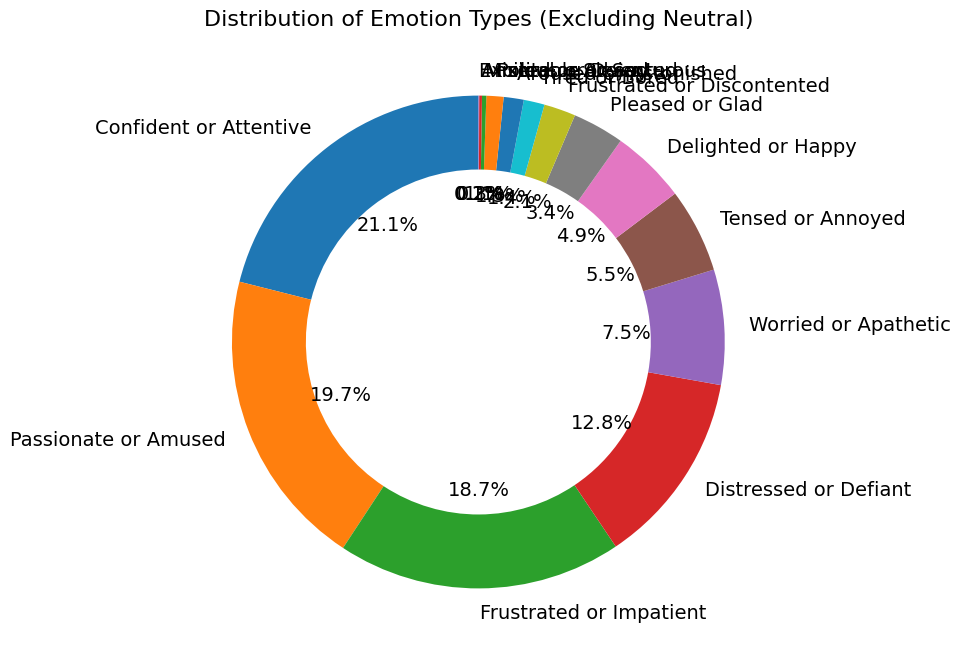


Age Group Distribution:
AGE
25-29    94126
20-24    68094
30-34    20437
35-39    13626
Name: count, dtype: int64
Total Instances in Age Groups: 196283


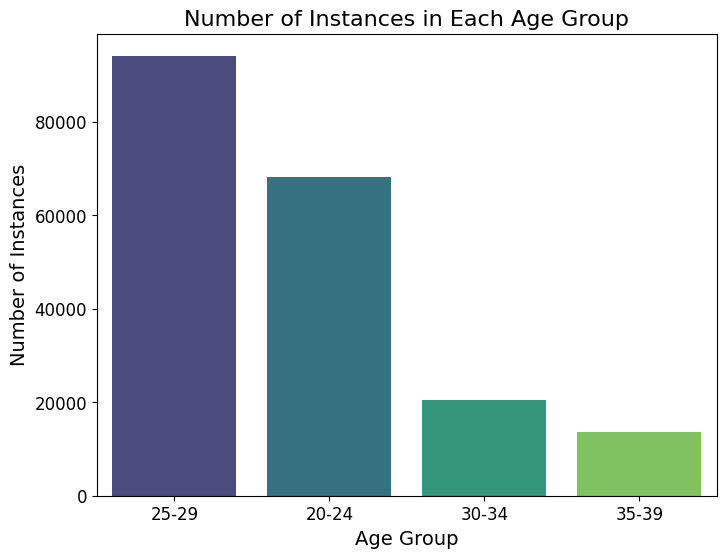


Gender Distribution:
GENDER
M    102182
F     94101
Name: count, dtype: int64
Total Instances in Gender Classes: 196283


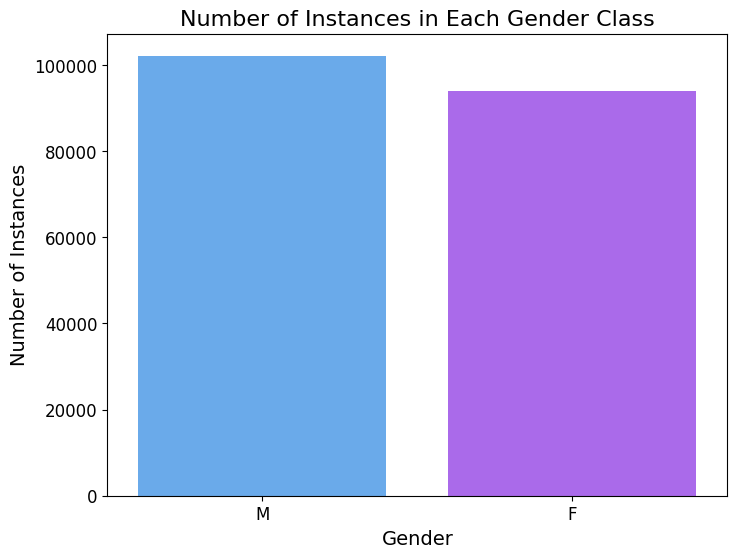

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example DataFrame (replace with your dataset)
# data = pd.read_csv("your_data.csv")

# 1. Heatmap for Gender and Age Distribution
plt.figure(figsize=(10, 6))

# Grouping data by Gender and Age and calculating the count
heatmap_data = data.groupby(['GENDER', 'AGE']).size().unstack(fill_value=0)

# Print the heatmap data and total count
print("Gender and Age Distribution (Heatmap Data):")
print(heatmap_data)
print(f"Total Instances: {heatmap_data.sum().sum()}")  # Total instances in the heatmap data

# Create the heatmap
sns.heatmap(
    heatmap_data, annot=True, cmap='coolwarm', fmt='d', linewidths=1, cbar=False,
    annot_kws={"size": 20}  # Adjust text size
)
plt.title('Heatmap of Instance Counts by Gender and Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=18)
plt.ylabel('Gender', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# 2. Donut Chart for Emotion_Type Distribution (with threshold)
percentage_threshold = 2.2  # Set the percentage threshold (e.g., 5%)
emotion_type_counts = data['Emotion'].value_counts()

# Calculate percentages
total_count = emotion_type_counts.sum()
emotion_type_percentages = (emotion_type_counts / total_count) * 100

# Print the emotion type counts, percentages, and total instances
print("\nEmotion Type Counts and Percentages:")
print(emotion_type_counts)
print(emotion_type_percentages)
print(f"Total Instances: {total_count}")  # Total instances in emotion type data

# Group smaller categories
emotion_type_counts_filtered = emotion_type_counts[emotion_type_percentages >= percentage_threshold]
others_count = emotion_type_counts[emotion_type_percentages < percentage_threshold].sum()
if others_count > 0:
    emotion_type_counts_filtered["Others"] = others_count

# Plot the initial donut chart
plt.figure(figsize=(8, 8))
plt.pie(
    emotion_type_counts_filtered, labels=emotion_type_counts_filtered.index, autopct='%1.1f%%', 
    startangle=90, textprops={'fontsize': 14}, wedgeprops={'width': 0.3}
)
plt.title(f'Distribution of Emotion Types (Below {percentage_threshold}% Grouped as Others)', fontsize=16)
plt.show()

# 3. Remove 'Neutral' instances and plot donut chart again
# Print the count of 'Neutral' instances before excluding
neutral_count = data[data['Emotion'] == 'Neutral'].shape[0]
print(f"\nNumber of Instances with 'Neutral': {neutral_count}")

# Remove 'Neutral' instances
data_no_neutral = data[data['Emotion'] != 'Neutral']

# Recalculate emotion type counts and percentages for non-neutral instances
emotion_type_counts_no_neutral = data_no_neutral['Emotion'].value_counts()

# Print the filtered emotion type counts and total instances
print("\nEmotion Type Counts (Excluding Neutral):")
print(emotion_type_counts_no_neutral)
print(f"Total Instances (Excluding Neutral): {emotion_type_counts_no_neutral.sum()}")  # Total instances excluding 'Neutral'

# Calculate percentages for non-neutral instances
emotion_type_percentages_no_neutral = (emotion_type_counts_no_neutral / emotion_type_counts_no_neutral.sum()) * 100
print("Emotion Type Percentages (Excluding Neutral):")
print(emotion_type_percentages_no_neutral)

# Plot the donut chart again without Neutral instances
plt.figure(figsize=(8, 8))
plt.pie(
    emotion_type_counts_no_neutral, labels=emotion_type_counts_no_neutral.index, autopct='%1.1f%%', 
    startangle=90, textprops={'fontsize': 14}, wedgeprops={'width': 0.3}
)
plt.title('Distribution of Emotion Types (Excluding Neutral)', fontsize=16)
plt.show()

# 4. Bar Plot for Age Group Distribution
plt.figure(figsize=(8, 6))

# Count the instances for each age group
age_counts = data['AGE'].value_counts()

# Print the age group distribution and total instances
print("\nAge Group Distribution:")
print(age_counts)
print(f"Total Instances in Age Groups: {age_counts.sum()}")  # Total instances in age groups

# Create the bar plot
sns.barplot(
    x=age_counts.index,
    y=age_counts.values,
    palette='viridis'
)
plt.title('Number of Instances in Each Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 5. Bar Plot for Gender Distribution
plt.figure(figsize=(8, 6))

# Count the instances for each gender
gender_counts = data['GENDER'].value_counts()

# Print the gender distribution and total instances
print("\nGender Distribution:")
print(gender_counts)
print(f"Total Instances in Gender Classes: {gender_counts.sum()}")  # Total instances in gender classes

# Create the bar plot
sns.barplot(
    x=gender_counts.index,
    y=gender_counts.values,
    palette='cool'
)
plt.title('Number of Instances in Each Gender Class', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Number of Instances', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


Missing values before cleaning:
ecg             1
bvp             1
gsr             1
rsp             1
skt             1
emg_coru        1
emg_trap        1
emg_zygo        1
Emotion         0
AGE             0
GENDER          0
Emotion_Type    0
dtype: int64

Missing values after cleaning:
ecg             1
bvp             1
gsr             1
rsp             1
skt             1
emg_coru        1
emg_trap        1
emg_zygo        1
Emotion         0
AGE             0
GENDER          0
Emotion_Type    0
dtype: int64
Target size per class: 3629

Old Emotion Class Distribution (excluding neutral):
Emotion
Confident or Attentive        18418
Passionate or Amused          17212
Frustrated or Impatient       16325
Distressed or Defiant         11175
Worried or Apathetic           6601
Tensed or Annoyed              4845
Delighted or Happy             4296
Pleased or Glad                2963
Frustrated or Discontented     1823
Tired or Bored                 1195
Aroused or Astonished        

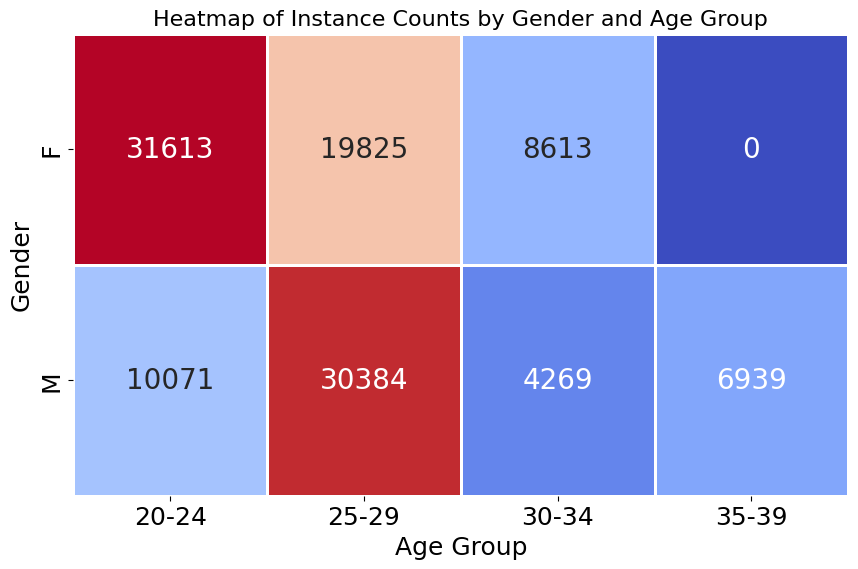


Emotion Distribution Information:
Emotion
Confident or Attentive        18418
Passionate or Amused          17212
Frustrated or Impatient       16325
Distressed or Defiant         11175
Worried or Apathetic           6601
Tensed or Annoyed              4845
Delighted or Happy             4296
Frustrated or Discontented     3797
Aroused or Astonished          3732
Polite or Sleepy               3696
Anxious or Dejected            3640
Miserable or Sad               3638
Excited or Adventurous         3634
Neutral                        3629
Pleased or Glad                3627
Tired or Bored                 3583
Name: count, dtype: int64
Total Instances in Emotion Distribution: 111848
Percentages for each class:
Emotion
Confident or Attentive        16.466991
Passionate or Amused          15.388742
Frustrated or Impatient       14.595701
Distressed or Defiant          9.991238
Worried or Apathetic           5.901760
Tensed or Annoyed              4.331772
Delighted or Happy             

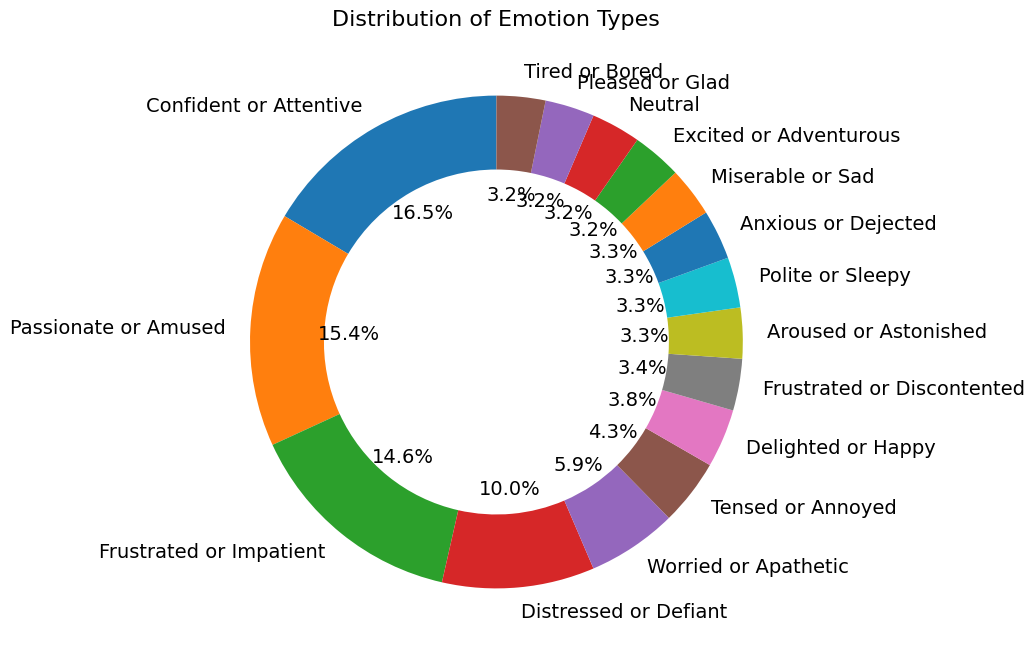


Age Group Distribution Information:
AGE
25-29    50211
20-24    41693
30-34    12882
35-39     6939
Name: count, dtype: int64
Total Instances in Age Group Distribution: 111725

Old vs New Age Group Counts (excluding Neutral):
25-29: Old=94126, New=50211, Difference=-43915
20-24: Old=68094, New=41693, Difference=-26401
30-34: Old=20437, New=12882, Difference=-7555
35-39: Old=13626, New=6939, Difference=-6687


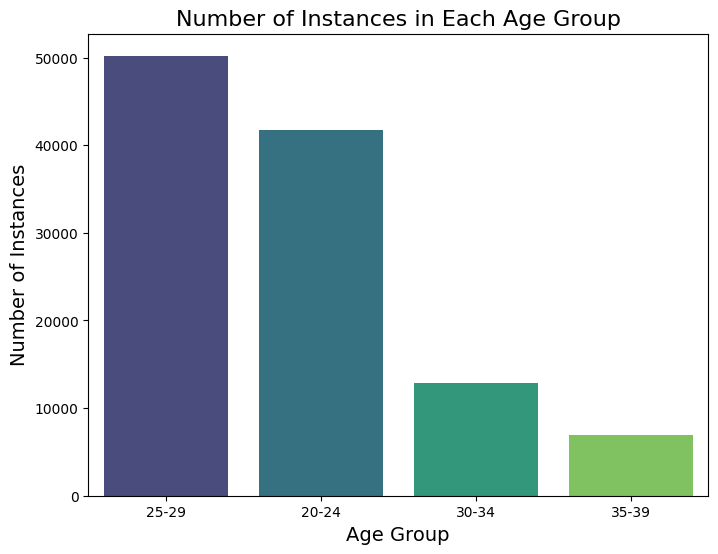


Gender Distribution Information:
GENDER
F    60095
M    51663
Name: count, dtype: int64
Total Instances in Gender Distribution: 111758

Old vs New Gender Class Counts (excluding Neutral):
M: Old=102182, New=51663, Difference=-50519
F: Old=94101, New=60095, Difference=-34006


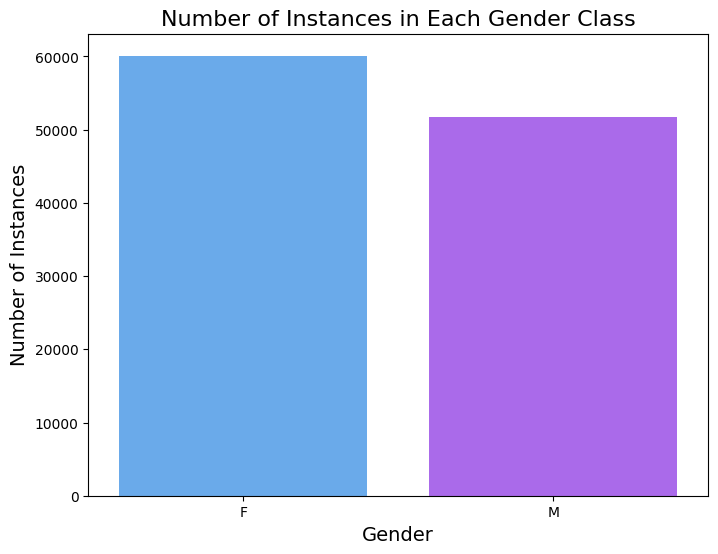

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.impute import SimpleImputer

def clean_data(data):
    """Cleans data by handling missing values in crucial columns."""
    df = data.copy()
    print("Missing values before cleaning:")
    print(df.isnull().sum())
    
    # Drop rows where crucial columns ('Emotion', 'GENDER', 'AGE') have missing values
    crucial_columns = ['Emotion', 'GENDER', 'AGE']
    df = df.dropna(subset=crucial_columns)
    
    print("\nMissing values after cleaning:")
    print(df.isnull().sum())
    return df

def balance_emotion_data(data):
    """Balances the Emotion data using ADASYN or SMOTE."""
    
    # Create a copy of the data to avoid modifying the original data
    df = data.copy()
    
    # Separate neutral emotion data from other emotions
    neutral_mask = df['Emotion'] == 'Neutral'
    df_neutral = df[neutral_mask]
    df_others = df[~neutral_mask]
    
    # Calculate target size for balanced classes
    emotion_counts = df['Emotion'].value_counts()
    target_size = int(np.median(emotion_counts))  # Use median as target size for balancing
    print(f"Target size per class: {target_size}")
    
    # Print old number of instances per class (excluding neutral instances)
    print("\nOld Emotion Class Distribution (excluding neutral):")
    emotion_counts_excluding_neutral = emotion_counts.drop('Neutral', errors='ignore')
    print(emotion_counts_excluding_neutral)
    print(f"Total Instances before balancing: {emotion_counts_excluding_neutral.sum()}")

    # Undersample neutral class to target size
    if len(df_neutral) > target_size:
        neutral_indices = np.random.choice(df_neutral.index, target_size, replace=False)
        df_neutral_balanced = df_neutral.loc[neutral_indices]
    else:
        df_neutral_balanced = df_neutral
    
    # Prepare the data for resampling
    df_combined = pd.concat([df_neutral_balanced, df_others])
    X = df_combined.drop(['Emotion', 'Emotion_Type'], axis=1)
    y = df_combined['Emotion']
    
    # Convert categorical variables to numeric codes
    X['GENDER'] = pd.Categorical(X['GENDER']).codes
    X['AGE'] = pd.Categorical(X['AGE']).codes
    
    # Handle missing values in numeric columns
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    imputer = SimpleImputer(strategy='mean')
    X_imputed = X.copy()
    X_imputed[numeric_columns] = imputer.fit_transform(X[numeric_columns])
    
    # Handle missing values in target variable 'y' if any
    y = y.fillna(y.mode()[0])
    
    # Create sampling strategy dictionary to control synthetic data generation
    sampling_strategy = {}
    for emotion in y.unique():
        count = Counter(y)[emotion]
        if count < target_size:
            sampling_strategy[emotion] = target_size
    
    # Apply ADASYN for resampling
    try:
        adasyn = ADASYN(random_state=42, n_neighbors=5, sampling_strategy=sampling_strategy)
        X_resampled, y_resampled = adasyn.fit_resample(X_imputed, y)
        
        # Print new number of instances after balancing
        print("\nNew Emotion Class Distribution (after ADASYN or SMOTE):")
        print(Counter(y_resampled))
        print(f"Total Instances after balancing: {sum(Counter(y_resampled).values())}")
        
    except ValueError as e:
        print(f"ADASYN failed with error: {str(e)}")
        print("Falling back to SMOTE...")
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
        X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

    # Convert back to DataFrame
    df_resampled = pd.DataFrame(X_resampled, columns=X_imputed.columns)
    df_resampled['Emotion'] = y_resampled
    
    # Convert numeric values back to categorical
    gender_map = {0: 'F', 1: 'M'}
    age_map = {0: '20-24', 1: '25-29', 2: '30-34', 3: '35-39'}
    
    df_resampled['GENDER'] = df_resampled['GENDER'].map(gender_map)
    df_resampled['AGE'] = df_resampled['AGE'].map(age_map)
    print(df_resampled.head())
    
    # Add back 'Emotion_Type'
    emotion_type_map = dict(zip(data['Emotion'], data['Emotion_Type']))
    df_resampled['Emotion_Type'] = df_resampled['Emotion'].map(emotion_type_map)
    
    return df_resampled, df

def create_visualizations(data, old_data):
    """Creates visualizations for the dataset."""
    
    # 1. Heatmap for Gender and Age Distribution
    print("\nHeatmap Information:")
    heatmap_data = data.groupby(['GENDER', 'AGE']).size().unstack(fill_value=0)
    print(heatmap_data)
    print(f"Total Instances in Heatmap: {heatmap_data.sum().sum()}")  # Total instances in the heatmap data
    
    # Print differences (excluding neutral)
    old_heatmap_data = old_data.groupby(['GENDER', 'AGE']).size().unstack(fill_value=0)
    old_heatmap_data_excluding_neutral = old_heatmap_data.drop('Neutral', errors='ignore')
    print("\nOld vs New Heatmap Data (excluding Neutral):")
    print(old_heatmap_data_excluding_neutral.sum().sum(), " (Old) vs", heatmap_data.sum().sum(), " (New)")
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_data, annot=True, cmap='coolwarm', fmt='d', linewidths=1, cbar=False,
        annot_kws={"size": 20}
    )
    plt.title('Heatmap of Instance Counts by Gender and Age Group', fontsize=16)
    plt.xlabel('Age Group', fontsize=18)
    plt.ylabel('Gender', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

    # 2. Donut Chart for Emotion Distribution
    print("\nEmotion Distribution Information:")
    emotion_counts = data['Emotion'].value_counts()
    total_count = emotion_counts.sum()
    emotion_percentages = (emotion_counts / total_count) * 100
    print(emotion_counts)
    print(f"Total Instances in Emotion Distribution: {total_count}")  # Total instances in emotion data
    print("Percentages for each class:")
    print(emotion_percentages)
    
    # Print the difference in Emotion Classes (excluding Neutral)
    old_emotion_counts = old_data['Emotion'].value_counts()
    old_emotion_counts_excluding_neutral = old_emotion_counts.drop('Neutral', errors='ignore')
    print(f"Old Emotion Instances (excluding Neutral): {old_emotion_counts_excluding_neutral}")
    
    # Ignore neutral instances in old data count for diff calculation
    print("\nOld vs New Emotion Class Counts (excluding Neutral):")
    for emotion in old_emotion_counts_excluding_neutral.index:
        old_count = old_emotion_counts_excluding_neutral[emotion]
        new_count = emotion_counts.get(emotion, 0)
        diff = new_count - old_count
        print(f"{emotion}: Old={old_count}, New={new_count}, Difference={diff}")
    
    plt.figure(figsize=(8, 8))
    plt.pie(
        emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%',
        startangle=90, textprops={'fontsize': 14}, wedgeprops={'width': 0.3}
    )
    plt.title('Distribution of Emotion Types', fontsize=16)
    plt.show()

    # 3. Bar Plot for Age Group Distribution
    print("\nAge Group Distribution Information:")
    age_counts = data['AGE'].value_counts()
    print(age_counts)
    print(f"Total Instances in Age Group Distribution: {age_counts.sum()}")  # Total instances in age groups
    
    # Print differences in age groups (excluding neutral)
    old_age_counts = old_data['AGE'].value_counts()
    old_age_counts_excluding_neutral = old_age_counts.drop('Neutral', errors='ignore')
    print("\nOld vs New Age Group Counts (excluding Neutral):")
    for age_group in old_age_counts_excluding_neutral.index:
        old_count = old_age_counts_excluding_neutral[age_group]
        new_count = age_counts.get(age_group, 0)
        diff = new_count - old_count
        print(f"{age_group}: Old={old_count}, New={new_count}, Difference={diff}")
    
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x=age_counts.index,
        y=age_counts.values,
        palette='viridis'
    )
    plt.title('Number of Instances in Each Age Group', fontsize=16)
    plt.xlabel('Age Group', fontsize=14)
    plt.ylabel('Number of Instances', fontsize=14)
    plt.show()

    # 4. Bar Plot for Gender Distribution
    print("\nGender Distribution Information:")
    gender_counts = data['GENDER'].value_counts()
    print(gender_counts)
    print(f"Total Instances in Gender Distribution: {gender_counts.sum()}")  # Total instances in gender classes
    
    # Print differences in gender classes (excluding neutral)
    old_gender_counts = old_data['GENDER'].value_counts()
    old_gender_counts_excluding_neutral = old_gender_counts.drop('Neutral', errors='ignore')
    print("\nOld vs New Gender Class Counts (excluding Neutral):")
    for gender in old_gender_counts_excluding_neutral.index:
        old_count = old_gender_counts_excluding_neutral[gender]
        new_count = gender_counts.get(gender, 0)
        diff = new_count - old_count
        print(f"{gender}: Old={old_count}, New={new_count}, Difference={diff}")
    
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x=gender_counts.index,
        y=gender_counts.values,
        palette='cool'
    )
    plt.title('Number of Instances in Each Gender Class', fontsize=16)
    plt.xlabel('Gender', fontsize=14)
    plt.ylabel('Number of Instances', fontsize=14)
    plt.show()

# Example workflow (replace 'data' with your dataset)
# data = pd.read_csv("your_dataset.csv")
cleaned_data = clean_data(data)
balanced_data, old_data = balance_emotion_data(cleaned_data)
create_visualizations(balanced_data, old_data)


In [9]:
print(len(balanced_data))
df = balanced_data
df['AGE'] = df['AGE'].replace({'20-24': '20-29', '25-29': '20-29', '30-34': '30-39', '35-39': '30-39'})
protected_attribute_names = ['AGE', 'GENDER']
df['AGE'] = df['AGE'].map({"20-29": 0, "30-39": 1})
df['GENDER'] = df['GENDER'].map({"M": 0, "F": 1})
emotion_labels = [
    'Neutral', 'Frustrated or Impatient', 'Tensed or Annoyed', 'Distressed or Defiant', 
    'Confident or Attentive', 'Passionate or Amused', 'Pleased or Glad', 'Delighted or Happy', 
    'Worried or Apathetic', 'Frustrated or Discontented', 'Aroused or Astonished', 'Miserable or Sad', 
    'Anxious or Dejected', 'Tired or Bored', 'Polite or Sleepy', 'Excited or Adventurous'
]
label_to_num = {label: num for num, label in enumerate(emotion_labels)}
print("Emotion Labels and Corresponding Encodings:")
print(label_to_num)
df['Emotion'] = df['Emotion'].replace(label_to_num)
emotion_type_map = {'Positive': 1, 'Negative': 0}
df['Emotion_Type'] = df['Emotion_Type'].replace(emotion_type_map)


111848
Emotion Labels and Corresponding Encodings:
{'Neutral': 0, 'Frustrated or Impatient': 1, 'Tensed or Annoyed': 2, 'Distressed or Defiant': 3, 'Confident or Attentive': 4, 'Passionate or Amused': 5, 'Pleased or Glad': 6, 'Delighted or Happy': 7, 'Worried or Apathetic': 8, 'Frustrated or Discontented': 9, 'Aroused or Astonished': 10, 'Miserable or Sad': 11, 'Anxious or Dejected': 12, 'Tired or Bored': 13, 'Polite or Sleepy': 14, 'Excited or Adventurous': 15}


<ipython-input-9-8310c4c55053>:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Emotion'] = df['Emotion'].replace(label_to_num)
<ipython-input-9-8310c4c55053>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Emotion_Type'] = df['Emotion_Type'].replace(emotion_type_map)


In [10]:
# Define label and protected attributes
label_names = ['Emotion_Type']
protected_attribute_names = ['AGE','GENDER']

# Define privileged and unprivileged groups
privileged_protected_attributes = [
    {"AGE": 1, "GENDER": 1}  # Privileged group (e.g., younger males)
]
unprivileged_protected_attributes = [
    {"AGE": 0, "GENDER": 0}  # Unprivileged group (e.g., older females)
]

# Drop missing values
df = df.dropna()

In [11]:
import tensorflow as tf

# Fair AI (AIF360) - Preprocessing, Inprocessing, Postprocessing Algorithms

In [12]:
import numpy as np
import pandas as pd
from aif360.algorithms.inprocessing import ExponentiatedGradientReduction, AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing, RejectOptionClassification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover, Reweighing
import time as time
import gc
# Create BinaryLabelDataset from the DataFrame
print("Creating BinaryLabelDataset...")
binary_dataset = BinaryLabelDataset(
    df=df,
    label_names=label_names,
    protected_attribute_names=protected_attribute_names
)
print("BinaryLabelDataset created.\n")


Creating BinaryLabelDataset...
BinaryLabelDataset created.



# Preprocessing - using DisparateImpactRemover and Reweighing

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from aif360.algorithms.preprocessing import DisparateImpactRemover, Reweighing
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

# Step 1: Apply Disparate Impact Remover
print("Applying Disparate Impact Remover...")
dir_remover = DisparateImpactRemover(repair_level=0.1, sensitive_attribute='AGE')
dir_processed = dir_remover.fit_transform(binary_dataset)

# Step 2: Apply Reweighing
print("\nApplying Reweighing...")
reweighing = Reweighing(
    privileged_groups=privileged_protected_attributes,
    unprivileged_groups=unprivileged_protected_attributes
)
reweighed_dataset = reweighing.fit_transform(binary_dataset)

# Step 3: Split the datasets into training and testing sets
train_dir, test_dir = dir_processed.split([0.8], shuffle=True)
train_reweighed, test_reweighed = reweighed_dataset.split([0.8], shuffle=True)

# Step 4: Extract features, labels, and instance weights for both datasets
def prepare_data(dataset):
    features = dataset.features
    labels = dataset.labels.flatten().astype(int)
    weights = dataset.instance_weights
    # Reshape features for GRU input
    features_reshaped = np.expand_dims(features, axis=2)
    return features_reshaped, labels, weights

# Disparate Impact Remover data
X_train_dir, y_train_dir, weights_train_dir = prepare_data(train_dir)
X_test_dir, y_test_dir, weights_test_dir = prepare_data(test_dir)

# Reweighed data
X_train_reweighed, y_train_reweighed, weights_train_reweighed = prepare_data(train_reweighed)
X_test_reweighed, y_test_reweighed, weights_test_reweighed = prepare_data(test_reweighed)

# Step 5: Build the GRU model
def build_gru_model(input_shape):
    model = Sequential([
        GRU(64, input_shape=input_shape, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate the model
def train_and_evaluate(X_train, y_train, weights_train, X_test, y_test, weights_test, description):
    print(f"\nTraining GRU model on {description} data...")
    model = build_gru_model((X_train.shape[1], X_train.shape[2]))
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        sample_weight=weights_train,
        validation_data=(X_test, y_test, weights_test),
        epochs=10,
        batch_size=32,
        verbose=1
    )
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, sample_weight=weights_test, verbose=0)
    print(f"{description} Test Loss: {loss:.4f}")
    print(f"{description} Test Accuracy: {accuracy:.4f}\n")
    return history, model

# Step 6: Train and evaluate the GRU on both datasets
dir_history, dir_model = train_and_evaluate(
    X_train_dir, y_train_dir, weights_train_dir,
    X_test_dir, y_test_dir, weights_test_dir,
    "Disparate Impact Remover"
)

reweighed_history, reweighed_model = train_and_evaluate(
    X_train_reweighed, y_train_reweighed, weights_train_reweighed,
    X_test_reweighed, y_test_reweighed, weights_test_reweighed,
    "Reweighed"
)

# Step 7: Function to create BinaryLabelDataset from predictions
def create_classified_dataset(original_dataset, predictions):
    # Replace labels in the original dataset with model predictions
    classified_dataset = original_dataset.copy()
    classified_dataset.labels = predictions.reshape(-1, 1)
    return classified_dataset

# Step 8: Function to compute fairness metrics
def compute_fairness_metrics(original_dataset, classified_dataset, privileged_groups, unprivileged_groups, description):
    metrics = ClassificationMetric(
        original_dataset,
        classified_dataset,
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups
    )
    
    # Print various fairness metrics
    print(f"\nFairness Metrics for {description}:")
    print(f"  Average Odds Difference: {metrics.average_odds_difference():.4f}")
    print(f"  Base Rate: {metrics.base_rate():.4f}")
    print(f"  Differential Fairness Bias Amplification: {metrics.differential_fairness_bias_amplification():.4f}")
    print(f"  Disparate Impact: {metrics.disparate_impact():.4f}")
    print(f"  Equal Opportunity Difference: {metrics.equal_opportunity_difference():.4f}")
    print(f"  Equalized Odds Difference: {metrics.equalized_odds_difference():.4f}")
    print(f"  False Positive Rate Difference: {metrics.false_positive_rate_difference():.4f}")
    print(f"  Theil Index: {metrics.theil_index():.4f}")
    print(f"  Statistical Parity Difference: {metrics.statistical_parity_difference():.4f}")
    print(f"  Selection Rate: {metrics.selection_rate():.4f}")
    
    return metrics

# Step 9: Get model predictions and compute metrics
# Predictions for the Disparate Impact Remover model
dir_predictions = dir_model.predict(X_test_dir).flatten()
dir_predictions = (dir_predictions >= 0.5).astype(int)  # Convert probabilities to binary predictions
classified_dir = create_classified_dataset(test_dir, dir_predictions)
dir_metrics = compute_fairness_metrics(
    test_dir, classified_dir, 
    privileged_protected_attributes, unprivileged_protected_attributes,
    "Disparate Impact Remover"
)

# Predictions for the Reweighed model
reweighed_predictions = reweighed_model.predict(X_test_reweighed).flatten()
reweighed_predictions = (reweighed_predictions >= 0.5).astype(int)  # Convert probabilities to binary predictions
classified_reweighed = create_classified_dataset(test_reweighed, reweighed_predictions)
reweighed_metrics = compute_fairness_metrics(
    test_reweighed, classified_reweighed, 
    privileged_protected_attributes, unprivileged_protected_attributes,
    "Reweighed"
)

# Step 10: Compute Binary Confusion Matrix for both models
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(y_true, y_pred, description):
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix for {description}:")
    print(cm)
    return cm

# Confusion matrix for Disparate Impact Remover model
print_confusion_matrix(y_test_dir, dir_predictions, "Disparate Impact Remover")

# Confusion matrix for Reweighed model
print_confusion_matrix(y_test_reweighed, reweighed_predictions, "Reweighed")


Applying Disparate Impact Remover...

Applying Reweighing...

Training GRU model on Disparate Impact Remover data...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2793/2793 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.8409 - loss: 0.3328 - val_accuracy: 0.9984 - val_loss: 0.0149
Epoch 2/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9924 - loss: 0.0282 - val_accuracy: 0.9970 - val_loss: 0.0124
Epoch 3/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9968 - loss: 0.0130 - val_accuracy: 0.9991 - val_loss: 0.0020
Epoch 4/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9976 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 5.0023e-04
Epoch 5/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9980 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 4.1613e-04
Epoch 6/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9986 - loss: 0.0045 - val_accuracy: 0.9992 - val_loss: 0.0022
Epoch 7/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9989 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 4.1071e-05
Epoch 8/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9993 - loss: 

array([[10663,     0],
       [   16, 11664]])

In [14]:
# import numpy as np
# import pandas as pd
# from aif360.algorithms.inprocessing import ExponentiatedGradientReduction, AdversarialDebiasing, PrejudiceRemover
# from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing, RejectOptionClassification
# from sklearn.linear_model import LogisticRegression
# from aif360.datasets import BinaryLabelDataset
# from aif360.metrics import BinaryLabelDatasetMetric
# from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
# from aif360.algorithms.preprocessing import DisparateImpactRemover, Reweighing, OptimPreproc, LFR
# import time as time
# import gc

# # Create BinaryLabelDataset from the DataFrame
# print("Creating BinaryLabelDataset...")
# binary_dataset = BinaryLabelDataset(
#     df=df,
#     label_names=label_names,
#     protected_attribute_names=protected_attribute_names
# )
# print("BinaryLabelDataset created.\n")

# metric = BinaryLabelDatasetMetric(
#     dataset=binary_dataset,
#     privileged_groups=privileged_protected_attributes,
#     unprivileged_groups=unprivileged_protected_attributes
# )

# # Calculate Statistical Parity Difference
# spd = metric.statistical_parity_difference()
# print(f"Statistical Parity Difference before any Fairness processing (SPD): {spd}\n")

# # Function to compare rows before and after repair
# def evaluate_transformation(original, repaired):
#     print("Evaluating transformation...")
#     original_features = original.features
#     repaired_features = repaired.features

#     # Count the number of changed rows
#     changed_rows = (original_features != repaired_features).any(axis=1).sum()
#     total_rows = original_features.shape[0]
#     percentage_changed = (changed_rows / total_rows) * 100

#     print(f"Total rows: {total_rows}")
#     print(f"Changed rows: {changed_rows}")
#     print(f"Percentage of changed rows: {percentage_changed:.2f}%\n")

# print("Applying transformation with Optimized Preprocessing...")
# lfr = LFR(
#     unprivileged_groups=unprivileged_protected_attributes,
#     privileged_groups=_privileged_protected_attributes,
#     k=5,             # Number of prototypes
#     Ax=0.01,         # Weight for utility term
#     Ay=1.0,          # Weight for classification accuracy
#     Az=50.0,         # Weight for fairness term
#     print_interval=1000,  # Frequency of status updates
#     verbose=1,       # Enable verbose output
#     seed=42          # Seed for reproducibility
# )


# print("Transforming dataset using LFR...")
# rep_df = lfr.fit_transform(
#     dataset=binary_dataset,  # Your BinaryLabelDataset
#     maxiter=5000,            # Maximum number of iterations
#     maxfun=5000,             # Maximum number of function evaluations
#     threshold=0.5            # Threshold for binary predictions
# )
# # Evaluate the transformed dataset
# print("LFR transformation complete.\n")
# evaluate_transformation(binary_dataset, rep_df)


# def apply_exponentiated_gradient_reduction(rep_df, privileged_protected_attributes, unprivileged_protected_attributes, sess=None):
#     print("Applying Exponentiated Gradient Reduction...")
#     try:
#         log_reg_estimator = LogisticRegression(max_iter=1000)
#         exp_grad_reduction = ExponentiatedGradientReduction(
#             estimator=log_reg_estimator,
#             constraints='EqualizedOdds',
#             eps=0.1,
#             nu=1e-5,
#             run_linprog_step=True
#         )
#         exp_grad_reduction_model = exp_grad_reduction.fit(rep_df)
#         exp_grad_reduction_pred = exp_grad_reduction_model.predict(rep_df)
#         return exp_grad_reduction_pred
#     except Exception as standard_error:
#         try:
#             print("Falling back to manual conversion for Exponentiated Gradient Reduction...")
#             rep_df_df = rep_df.convert_to_dataframe()[0]
#             X = rep_df_df.drop(columns=['Emotion_Type'])
#             y = rep_df_df['Emotion_Type']
#             log_reg_estimator = LogisticRegression(max_iter=1000)
#             exp_grad_reduction = ExponentiatedGradientReduction(
#                 estimator=log_reg_estimator,
#                 constraints='EqualizedOdds',
#                 eps=0.1,
#                 nu=1e-5,
#                 run_linprog_step=True,
#                 drop_prot_attr=False,
#                 prot_attr='AGE'
#             )
#             exp_grad_reduction.fit(X, y)
#             y_pred = exp_grad_reduction.predict(X)
#             X_with_pred = X.copy()
#             X_with_pred['Emotion_Type'] = y_pred
#             new_bld = BinaryLabelDataset(
#                 df=X_with_pred,
#                 label_names=['Emotion_Type'],
#                 protected_attribute_names=['AGE']
#             )
#             return new_bld
#         except Exception as fallback_error:
#             raise

# def main_bias_mitigation_workflow(rep_df, privileged_protected_attributes, unprivileged_protected_attributes, sess=None):
#     print("Starting bias mitigation workflow...")
#     in_processing_methods = {
#         'ExponentiatedGradientReduction': 
#             lambda: apply_exponentiated_gradient_reduction(
#                 rep_df, 
#                 privileged_protected_attributes, 
#                 unprivileged_protected_attributes, 
#                 sess
#             ),
#         'AdversarialDebiasing': 
#             lambda: AdversarialDebiasing(
#                 privileged_groups=privileged_protected_attributes,
#                 unprivileged_groups=unprivileged_protected_attributes,
#                 scope_name='adversarial_classifier',
#                 debias=True,
#                 sess=sess,
#                 seed=42,
#                 adversary_loss_weight=1.0,
#                 num_epochs=2,
#                 batch_size=128,
#                 classifier_num_hidden_units=128
#             ).fit(rep_df).predict(rep_df),
#         'PrejudiceRemover': 
#             lambda: PrejudiceRemover(
#                 eta=1.0,  
#                 sensitive_attr='AGE'
#             ).fit(rep_df).predict(rep_df)
#     }

#     post_processing_methods = {
#         'EqOddsPostprocessing': 
#             lambda predicted_dataset: EqOddsPostprocessing(
#                 privileged_groups=privileged_protected_attributes,
#                 unprivileged_groups=unprivileged_protected_attributes
#             ).fit(rep_df, predicted_dataset).predict(rep_df),
#         'CalibratedEqOddsPostprocessing': 
#             lambda predicted_dataset: CalibratedEqOddsPostprocessing(
#                 privileged_groups=privileged_protected_attributes,
#                 unprivileged_groups=unprivileged_protected_attributes
#             ).fit(rep_df, predicted_dataset).predict(rep_df),
#         'RejectOptionClassification': 
#             lambda predicted_dataset: RejectOptionClassification(
#                 privileged_groups=privileged_protected_attributes,
#                 unprivileged_groups=unprivileged_protected_attributes
#             ).fit(rep_df, predicted_dataset).predict(rep_df)
#     }

#     results = {}

#     for in_method_name, in_method_func in in_processing_methods.items():
#         try:
#             print(f"Applying in-processing method: {in_method_name}...")
#             in_method_pred = in_method_func()
#             metric = BinaryLabelDatasetMetric(
#                 in_method_pred, 
#                 unprivileged_groups=unprivileged_protected_attributes, 
#                 privileged_groups=privileged_protected_attributes
#             )
#             stat_parity_diff = metric.statistical_parity_difference()
#             results[in_method_name] = {'statistical_parity_difference': stat_parity_diff}
#             print(f"Completed in-processing method: {in_method_name}, SPD: {stat_parity_diff}\n")
            
#             for post_method_name, post_method_func in post_processing_methods.items():
#                 print(f"Applying post-processing method: {post_method_name} for {in_method_name}...")
#                 post_method_pred = post_method_func(in_method_pred)
#                 post_metric = BinaryLabelDatasetMetric(
#                     post_method_pred, 
#                     unprivileged_groups=unprivileged_protected_attributes, 
#                     privileged_groups=privileged_protected_attributes
#                 )
#                 post_stat_parity_diff = post_metric.statistical_parity_difference()
#                 results[f"{in_method_name}_{post_method_name}"] = {
#                     'base_method': in_method_name,
#                     'post_method': post_method_name,
#                     'statistical_parity_difference': post_stat_parity_diff
#                 }
#                 print(f"Completed post-processing method: {post_method_name}, SPD: {post_stat_parity_diff}\n")
#         except Exception as e:
#             print(f"Error in method {in_method_name}: {e}\n")
#             continue

#     print("Bias mitigation workflow complete.\nResults:")
#     for key, value in results.items():
#         print(f"{key}: Statistical Parity Difference = {value['statistical_parity_difference']:.4f}")

#     return results

# # Run the workflow
# results = main_bias_mitigation_workflow(
#     rep_df,
#     privileged_protected_attributes,
#     unprivileged_protected_attributes,
#     sess=sess
# )

In [15]:
# ###### import numpy as np
# import pandas as pd
# from aif360.algorithms.inprocessing import ExponentiatedGradientReduction, AdversarialDebiasing, PrejudiceRemover
# from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing, RejectOptionClassification
# from sklearn.linear_model import LogisticRegression
# from aif360.datasets import BinaryLabelDataset
# from aif360.metrics import BinaryLabelDatasetMetric
# from aif360.algorithms.preprocessing import DisparateImpactRemover, Reweighing

# # Create BinaryLabelDataset from the DataFrame
# binary_dataset = BinaryLabelDataset(
#     df=df,
#     label_names=label_names,
#     protected_attribute_names=protected_attribute_names
# )
# metric = BinaryLabelDatasetMetric(
#     dataset=binary_dataset,
#     privileged_groups=privileged_protected_attributes,
#     unprivileged_groups=unprivileged_protected_attributes
# )

# # Calculate Statistical Parity Difference
# spd = metric.statistical_parity_difference()

# # Print the result
# print(f"Statistical Parity Difference before any Fairness processing (SPD): {spd}")

# # Function to compare rows before and after repair
# def evaluate_transformation(original, repaired):
#     original_features = original.features
#     repaired_features = repaired.features

#     # Count the number of changed rows
#     changed_rows = (original_features != repaired_features).any(axis=1).sum()
#     total_rows = original_features.shape[0]
#     percentage_changed = (changed_rows / total_rows) * 100

#     print(f"Total rows: {total_rows}")
#     print(f"Changed rows: {changed_rows}")
#     print(f"Percentage of changed rows: {percentage_changed:.2f}%\n")

# # Print sample features for original and repaired datasets
# print("Original Dataset Features:\n", binary_dataset.features[:5])

# # Apply the Disparate Impact Remover
# dir_remover = DisparateImpactRemover(repair_level=0.1, sensitive_attribute='AGE')
# rep_df = dir_remover.fit_transform(binary_dataset)

# # Print sample features for the repaired dataset
# print("Repaired Dataset Features:\n", rep_df.features[:5])

# # Evaluate the transformation
# print("=== Evaluation of Transformation ===")
# evaluate_transformation(binary_dataset, rep_df)
# print(rep_df)

# def apply_exponentiated_gradient_reduction(rep_df, privileged_protected_attributes, unprivileged_protected_attributes, sess=None):
#     try:
#         log_reg_estimator = LogisticRegression(max_iter=1000)
#         exp_grad_reduction = ExponentiatedGradientReduction(
#             estimator=log_reg_estimator,
#             constraints='EqualizedOdds',
#             eps=0.1,
#             nu=1e-5,
#             run_linprog_step=True
#         )
#         exp_grad_reduction_model = exp_grad_reduction.fit(rep_df)
#         exp_grad_reduction_pred = exp_grad_reduction_model.predict(rep_df)
#         return exp_grad_reduction_pred
#     except Exception as standard_error:
#         try:
#             print("Falling back to manual conversion for Exponentiated Gradient Reduction...")
#             rep_df_df = rep_df.convert_to_dataframe()[0]
#             X = rep_df_df.drop(columns=['Emotion_Type'])
#             y = rep_df_df['Emotion_Type']
#             log_reg_estimator = LogisticRegression(max_iter=1000)
#             exp_grad_reduction = ExponentiatedGradientReduction(
#                 estimator=log_reg_estimator,
#                 constraints='EqualizedOdds',
#                 eps=0.1,
#                 nu=1e-5,
#                 run_linprog_step=True,
#                 drop_prot_attr=False,
#                 prot_attr='AGE'
#             )
#             exp_grad_reduction.fit(X, y)
#             y_pred = exp_grad_reduction.predict(X)
#             X_with_pred = X.copy()
#             X_with_pred['Emotion_Type'] = y_pred
#             new_bld = BinaryLabelDataset(
#                 df=X_with_pred,
#                 label_names=['Emotion_Type'],
#                 protected_attribute_names=['AGE']
#             )
#             return new_bld
#         except Exception as fallback_error:
#             raise

# def main_bias_mitigation_workflow(rep_df, privileged_protected_attributes, unprivileged_protected_attributes, sess=None):
#     in_processing_methods = {
#         'ExponentiatedGradientReduction': 
#             lambda: apply_exponentiated_gradient_reduction(
#                 rep_df, 
#                 privileged_protected_attributes, 
#                 unprivileged_protected_attributes, 
#                 sess
#             ),
#         'AdversarialDebiasing': 
#             lambda: AdversarialDebiasing(
#                 privileged_groups=privileged_protected_attributes,
#                 unprivileged_groups=unprivileged_protected_attributes,
#                 scope_name='adversarial_classifier',
#                 debias=True,
#                 sess=sess,
#                 seed=42,
#                 adversary_loss_weight=1.0,
#                 num_epochs=2,
#                 batch_size=32,
#                 classifier_num_hidden_units=128
#             ).fit(rep_df).predict(rep_df),
#         'PrejudiceRemover': 
#             lambda: PrejudiceRemover(
#                 eta=1.0,  
#                 sensitive_attr='AGE'
#             ).fit(rep_df).predict(rep_df)
#     }

#     post_processing_methods = {
#         'EqOddsPostprocessing': 
#             lambda predicted_dataset: EqOddsPostprocessing(
#                 privileged_groups=privileged_protected_attributes,
#                 unprivileged_groups=unprivileged_protected_attributes
#             ).fit(rep_df, predicted_dataset).predict(rep_df),
#         'CalibratedEqOddsPostprocessing': 
#             lambda predicted_dataset: CalibratedEqOddsPostprocessing(
#                 privileged_groups=privileged_protected_attributes,
#                 unprivileged_groups=unprivileged_protected_attributes
#             ).fit(rep_df, predicted_dataset).predict(rep_df),
#         'RejectOptionClassification': 
#             lambda predicted_dataset: RejectOptionClassification(
#                 privileged_groups=privileged_protected_attributes,
#                 unprivileged_groups=unprivileged_protected_attributes
#             ).fit(rep_df, predicted_dataset).predict(rep_df)
#     }

#     results = {}

#     for in_method_name, in_method_func in in_processing_methods.items():
#         try:
#             in_method_pred = in_method_func()
#             metric = BinaryLabelDatasetMetric(
#                 in_method_pred, 
#                 unprivileged_groups=unprivileged_protected_attributes, 
#                 privileged_groups=privileged_protected_attributes
#             )
#             stat_parity_diff = metric.statistical_parity_difference()
#             results[in_method_name] = {'statistical_parity_difference': stat_parity_diff}
#             for post_method_name, post_method_func in post_processing_methods.items():
#                 post_method_pred = post_method_func(in_method_pred)
#                 post_metric = BinaryLabelDatasetMetric(
#                     post_method_pred, 
#                     unprivileged_groups=unprivileged_protected_attributes, 
#                     privileged_groups=privileged_protected_attributes
#                 )
#                 post_stat_parity_diff = post_metric.statistical_parity_difference()
#                 results[f"{in_method_name}_{post_method_name}"] = {
#                     'base_method': in_method_name,
#                     'post_method': post_method_name,
#                     'statistical_parity_difference': post_stat_parity_diff
#                 }
#         except Exception as e:
#             continue

#     for key, value in results.items():
#         print(f"{key}: Statistical Parity Difference = {value['statistical_parity_difference']:.4f}")

#     return results

# results = main_bias_mitigation_workflow(
#     rep_df,
#     privileged_protected_attributes,
#     unprivileged_protected_attributes,
#     sess=sess
# )


In [16]:
# import numpy as np
# import pandas as pd
# from aif360.algorithms.inprocessing import ExponentiatedGradientReduction, AdversarialDebiasing, PrejudiceRemover
# from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing, RejectOptionClassification
# from aif360.datasets import BinaryLabelDataset
# from aif360.metrics import BinaryLabelDatasetMetric
# from aif360.algorithms.preprocessing import Reweighing

# print("Initializing BinaryLabelDataset...")
# binary_dataset = BinaryLabelDataset(
#     df=df,
#     label_names=label_names,
#     protected_attribute_names=protected_attribute_names
# )

# metric = BinaryLabelDatasetMetric(
#     dataset=binary_dataset,
#     privileged_groups=privileged_protected_attributes,
#     unprivileged_groups=unprivileged_protected_attributes
# )

# spd = metric.statistical_parity_difference()
# print(f"Statistical Parity Difference before any Fairness processing (SPD): {spd}")

# def evaluate_transformation_weights(original, repaired):
#     original_weights = original.instance_weights
#     repaired_weights = repaired.instance_weights
#     changed_rows = (original_weights != repaired_weights).sum()
#     total_rows = len(original_weights)
#     percentage_changed = (changed_rows / total_rows) * 100
#     print(f"Total rows: {total_rows}")
#     print(f"Changed rows: {changed_rows}")
#     print(f"Percentage of changed rows: {percentage_changed:.2f}%\n")

# print("Applying Reweighing algorithm...")
# reweighing = Reweighing(
#     privileged_groups=privileged_protected_attributes,
#     unprivileged_groups=unprivileged_protected_attributes
# )

# rep_df = reweighing.fit_transform(binary_dataset)

# print("Evaluating transformation after Reweighing...")
# evaluate_transformation_weights(binary_dataset, rep_df)

# def apply_exponentiated_gradient_reduction(rep_df, privileged_protected_attributes, unprivileged_protected_attributes, sess=None):
#     print("Applying Exponentiated Gradient Reduction...")
#     try:
#         log_reg_estimator = LogisticRegression(max_iter=1000)
#         exp_grad_reduction = ExponentiatedGradientReduction(
#             estimator=log_reg_estimator,
#             constraints='EqualizedOdds',
#             eps=0.1,
#             nu=1e-5,
#             run_linprog_step=True
#         )
#         exp_grad_reduction_model = exp_grad_reduction.fit(rep_df)
#         exp_grad_reduction_pred = exp_grad_reduction_model.predict(rep_df)
#         return exp_grad_reduction_pred
#     except Exception as standard_error:
#         try:
#             print("Falling back to manual conversion for Exponentiated Gradient Reduction...")
#             rep_df_df = rep_df.convert_to_dataframe()[0]
#             X = rep_df_df.drop(columns=['Emotion_Type'])
#             y = rep_df_df['Emotion_Type']
#             log_reg_estimator = LogisticRegression(max_iter=1000)
#             exp_grad_reduction = ExponentiatedGradientReduction(
#                 estimator=log_reg_estimator,
#                 constraints='EqualizedOdds',
#                 eps=0.1,
#                 nu=1e-5,
#                 run_linprog_step=True,
#                 drop_prot_attr=False,
#                 prot_attr='AGE'
#             )
#             exp_grad_reduction.fit(X, y)
#             y_pred = exp_grad_reduction.predict(X)
#             X_with_pred = X.copy()
#             X_with_pred['Emotion_Type'] = y_pred
#             new_bld = BinaryLabelDataset(
#                 df=X_with_pred,
#                 label_names=['Emotion_Type'],
#                 protected_attribute_names=['AGE']
#             )
#             return new_bld
#         except Exception as fallback_error:
#             raise

# def main_bias_mitigation_workflow(rep_df, privileged_protected_attributes, unprivileged_protected_attributes, sess=None):
#     in_processing_methods = {
#         'ExponentiatedGradientReduction': 
#             lambda: apply_exponentiated_gradient_reduction(
#                 rep_df, 
#                 privileged_protected_attributes, 
#                 unprivileged_protected_attributes, 
#                 sess
#             ),
#         'AdversarialDebiasing': 
#             lambda: AdversarialDebiasing(
#                 privileged_groups=privileged_protected_attributes,
#                 unprivileged_groups=unprivileged_protected_attributes,
#                 scope_name='adversarial_classifier',
#                 debias=True,
#                 sess=sess,
#                 seed=42,
#                 adversary_loss_weight=1.0,
#                 num_epochs=2,
#                 batch_size=32,
#                 classifier_num_hidden_units=128
#             ).fit(rep_df).predict(rep_df),
#         'PrejudiceRemover': 
#             lambda: PrejudiceRemover(
#                 eta=1.0,  
#                 sensitive_attr='AGE'
#             ).fit(rep_df).predict(rep_df)
#     }

#     post_processing_methods = {
#         'EqOddsPostprocessing': 
#             lambda predicted_dataset: EqOddsPostprocessing(
#                 privileged_groups=privileged_protected_attributes,
#                 unprivileged_groups=unprivileged_protected_attributes
#             ).fit(rep_df, predicted_dataset).predict(rep_df),
#         'CalibratedEqOddsPostprocessing': 
#             lambda predicted_dataset: CalibratedEqOddsPostprocessing(
#                 privileged_groups=privileged_protected_attributes,
#                 unprivileged_groups=unprivileged_protected_attributes
#             ).fit(rep_df, predicted_dataset).predict(rep_df),
#         'RejectOptionClassification': 
#             lambda predicted_dataset: RejectOptionClassification(
#                 privileged_groups=privileged_protected_attributes,
#                 unprivileged_groups=unprivileged_protected_attributes
#             ).fit(rep_df, predicted_dataset).predict(rep_df)
#     }

#     results = {}
#     print("Starting in-processing methods...")
#     for in_method_name, in_method_func in in_processing_methods.items():
#         try:
#             print(f"Processing: {in_method_name}...")
#             in_method_pred = in_method_func()
#             metric = BinaryLabelDatasetMetric(
#                 in_method_pred, 
#                 unprivileged_groups=unprivileged_protected_attributes, 
#                 privileged_groups=privileged_protected_attributes
#             )
#             stat_parity_diff = metric.statistical_parity_difference()
#             results[in_method_name] = {'statistical_parity_difference': stat_parity_diff}
#             print(f"Completed: {in_method_name} with SPD: {stat_parity_diff:.4f}")

#             for post_method_name, post_method_func in post_processing_methods.items():
#                 print(f"Applying post-processing: {post_method_name}...")
#                 post_method_pred = post_method_func(in_method_pred)
#                 post_metric = BinaryLabelDatasetMetric(
#                     post_method_pred, 
#                     unprivileged_groups=unprivileged_protected_attributes, 
#                     privileged_groups=privileged_protected_attributes
#                 )
#                 post_stat_parity_diff = post_metric.statistical_parity_difference()
#                 results[f"{in_method_name}_{post_method_name}"] = {
#                     'base_method': in_method_name,
#                     'post_method': post_method_name,
#                     'statistical_parity_difference': post_stat_parity_diff
#                 }
#                 print(f"Completed: {in_method_name}_{post_method_name} with SPD: {post_stat_parity_diff:.4f}")
#         except Exception as e:
#             print(f"Error in {in_method_name}: {e}")
#             continue

#     print("Results summary:")
#     for key, value in results.items():
#         print(f"{key}: Statistical Parity Difference = {value['statistical_parity_difference']:.4f}")

#     return results

# print("Starting bias mitigation workflow...")
# results = main_bias_mitigation_workflow(
#     rep_df,
#     privileged_protected_attributes,
#     unprivileged_protected_attributes,
#     sess=sess
# )


In [17]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, Bidirectional, LSTM, Attention, Add
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# class OptimizedKerasWrapper:
#     """
#     Optimized Keras GRU model for multiclass classification with fairness evaluation.
#     """
#     def __init__(self, input_size, output_size):
#         self.input_size = input_size
#         self.output_size = output_size
    
#     def build_model(self):
#         """
#         Define the GRU-LSTM model with attention and residual connections.
#         """
#         hidden_size = 512  # Fixed hidden size for simplicity
        
#         # Encoder Inputs
#         encoder_inputs = Input(shape=(None, self.input_size))
        
#         # First Bidirectional GRU Layer
#         encoder_gru1 = Bidirectional(GRU(hidden_size, return_sequences=True))(encoder_inputs)
#         encoder_gru1 = BatchNormalization()(encoder_gru1)
#         encoder_gru1 = Dropout(0.4)(encoder_gru1)
        
#         # Second Bidirectional GRU Layer
#         encoder_gru2 = Bidirectional(GRU(hidden_size, return_sequences=True))(encoder_gru1)
#         encoder_gru2 = BatchNormalization()(encoder_gru2)
#         encoder_gru2 = Dropout(0.4)(encoder_gru2)
        
#         # Attention Mechanism
#         attention_output = Attention()([encoder_gru2, encoder_gru2])
        
#         # Residual Connection
#         residual = Add()([encoder_gru2, attention_output])
        
#         # Decoder Part (LSTM)
#         decoder_lstm = LSTM(hidden_size)(residual)
#         decoder_lstm = BatchNormalization()(decoder_lstm)
#         decoder_lstm = Dropout(0.5)(decoder_lstm)
        
#         # Output Layer
#         decoder_outputs = Dense(self.output_size, activation='softmax')(decoder_lstm)
        
#         # Compile Model
#         model = Model(inputs=encoder_inputs, outputs=decoder_outputs)
#         model.compile(
#             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
#             loss='categorical_crossentropy',
#             metrics=['accuracy']
#         )
#         return model
    
#     def fit(self, X, y, sample_weight=None, validation_split=0.2):
#         """
#         Train the model using the provided data.
#         """
#         self.model = self.build_model()
#         X_reshaped = X.reshape(-1, 1, self.input_size)
        
#         # Callbacks
#         early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
#         lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4)
        
#         self.model.fit(
#             X_reshaped, y,
#             sample_weight=sample_weight,
#             batch_size=1024,
#             epochs=10,
#             verbose=1,
#             validation_split=validation_split,
#             callbacks=[early_stopping, lr_scheduler]
#         )
#         return self
    
#     def predict(self, X):
#         """
#         Make predictions using the trained model.
#         """
#         if len(X.shape) == 2:
#             X_reshaped = X.reshape(-1, 1, self.input_size)
#         else:
#             X_reshaped = X
#         return self.model.predict(X_reshaped)

# def preprocess_data(df_cleaned):
#     sensitive_features = ['AGE','GENDER']
#     target = 'Emotion'
#     emotion_type = 'Emotion_Type'
    
#     emotion_encoder = LabelEncoder()
#     df_cleaned[target] = emotion_encoder.fit_transform(df_cleaned[target])
#     emotion_mapping = dict(zip(emotion_encoder.classes_, emotion_encoder.transform(emotion_encoder.classes_)))
#     print(emotion_encoder.classes_)
    
#     label_encoder = LabelEncoder()
#     for feature in sensitive_features:
#         df_cleaned[feature] = label_encoder.fit_transform(df_cleaned[feature])
#     print(label_encoder.classes_)
#     print("length of df cleaned", len(df_cleaned.columns))
#     X = df_cleaned.drop(columns=[target]+[emotion_type])
#     for column in X.columns:
#         if X[column].dtype == 'object':
#             X[column] = label_encoder.fit_transform(X[column])
#     print(X.head())
    
#     y = tf.keras.utils.to_categorical(df_cleaned[target])
#     sens_features = df_cleaned[sensitive_features]
    
#     return X, y, sens_features, emotion_mapping

# def plot_confusion_matrix(y_true, y_pred, emotion_mapping):
#     """
#     Plot confusion matrix for multiclass classification.
#     """
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(12, 10))
#     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title('Confusion Matrix')
#     plt.colorbar()

#     emotion_labels = {v: k for k, v in emotion_mapping.items()}
#     tick_marks = np.arange(len(emotion_labels))
#     plt.xticks(tick_marks, [emotion_labels[i] for i in range(len(emotion_labels))], rotation=45, ha='right')
#     plt.yticks(tick_marks, [emotion_labels[i] for i in range(len(emotion_labels))])
#     thresh = cm.max() / 2.
#     for i, j in np.ndindex(cm.shape):
#         plt.text(j, i, format(cm[i, j], 'd'),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.tight_layout()
#     plt.show()


# required_columns = [
#     'ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_coru', 'emg_trap',
#     'emg_zygo', 'Emotion', 'AGE', 'GENDER'
# ]

# missing_columns = [col for col in required_columns if col not in df.columns]
# if missing_columns:
#     print(f"Missing required columns: {missing_columns}")

# print("Checking for missing values...")
# print(df.isnull().sum())
# print("Dropping missing values...")
# df_cleaned = df.dropna()
# print(f"Dataset shape after cleaning: {df_cleaned.shape}")

# print("\nPreprocessing data...")
# X, y, sensitive_features, emotion_mapping = preprocess_data(df_cleaned)

# age_labels = ['20-24', '25-29', '30-34', '35-39']
# gender_labels = ['Male', 'Female']

# print("\nTraining and evaluating model...")

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# # Apply StandardScaler after train-test split
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_df = X_test
# X_test = scaler.transform(X_test)

# input_size = X_train.shape[1]
# output_size = y_train.shape[1]

# print("\nTraining optimized model...")
# optimized_model = OptimizedKerasWrapper(input_size, output_size)
# optimized_model.fit(X_train, y_train)

# print("\nGenerating predictions...")
# y_pred = optimized_model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_test_classes = np.argmax(y_test, axis=1)

# print("\nOverall Optimized Model Performance:")
# print(classification_report(y_test_classes, y_pred_classes))

# plot_confusion_matrix(y_test_classes, y_pred_classes, emotion_mapping)


In [18]:
# from aif360.metrics import ClassificationMetric
# def generate_datasets(X_test, y_test, y_pred_classes, emotion_mapping):
#     """
#     Generate original and predicted datasets with proper column names.
#     """
#     # Reverse mapping for emotions
#     reverse_emotion_mapping = {v: k for k, v in emotion_mapping.items()}
#     y_test_classes = np.argmax(y_test, axis=1)
    
#     # Define positive emotions
#     positive_emotions = {0, 4, 5, 6, 7, 10, 15}
    
#     # Original dataset
#     original_emotion = [reverse_emotion_mapping[emotion] for emotion in y_test_classes]
#     original_emotion_type = [1 if emotion in positive_emotions else 0 for emotion in y_test_classes]
#     original_df = pd.DataFrame(X_test, columns=['ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_coru', 'emg_trap', 'emg_zygo', 'AGE', 'GENDER'])
# #     original_df['Emotion'] = original_emotion
#     original_df['Emotion_Type'] = original_emotion_type
    
#     # Predicted dataset
#     predicted_emotion = [reverse_emotion_mapping[emotion] for emotion in y_pred_classes]
#     predicted_emotion_type = [1 if emotion in positive_emotions else 0 for emotion in y_pred_classes]
#     predicted_df = pd.DataFrame(X_test, columns=['ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_coru', 'emg_trap', 'emg_zygo', 'AGE', 'GENDER'])
# #     predicted_df['Emotion'] = predicted_emotion
#     predicted_df['Emotion_Type'] = predicted_emotion_type
    
#     return original_df, predicted_df

# # Generate the datasets
# y_pred = optimized_model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# original_test_data, predicted_test_data = generate_datasets(X_df, y_test, y_pred_classes, emotion_mapping)

# # Display the first few rows of each dataset
# print("\nOriginal Test Data:")
# print(original_test_data.head())

# print("\nPredicted Test Data:")
# print(predicted_test_data.head())

# privileged_protected_attributes = [
#     {"AGE": 0, "GENDER": 0}
# ]
# unprivileged_protected_attributes = [
#     {"AGE": 1, "GENDER": 1}
# ]
# label_names = ['Emotion_Type']
# bdata_test = BinaryLabelDataset(
#     df=original_test_data,
#     label_names=label_names,a
#     protected_attribute_names=protected_attribute_names,
#     privileged_protected_attributes=privileged_protected_attributes
# )

# bdata_pred = BinaryLabelDataset(
#     df=predicted_test_data,
#     label_names=label_names,
#     protected_attribute_names=protected_attribute_names,
#     privileged_protected_attributes=privileged_protected_attributes
# )

# metric = ClassificationMetric(
#     dataset=bdata_test,
#     classified_dataset=bdata_pred,
#     privileged_groups=privileged_protected_attributes,
#     unprivileged_groups=unprivileged_protected_attributes
# )

# average_odds_diff = metric.average_odds_difference()
# disparate_impact = metric.disparate_impact()
# equal_opportunity_diff = metric.equal_opportunity_difference()
# equalized_odds_diff = metric.equalized_odds_difference()
# theil_index = metric.theil_index()
# selection_rate = metric.selection_rate()

# print(f"Average Odds Difference: {average_odds_diff:.4f}")
# print(f"Disparate Impact: {disparate_impact:.4f}")
# print(f"Equal Opportunity Difference: {equal_opportunity_diff:.4f}")
# print(f"Equalized Odds Difference: {equalized_odds_diff:.4f}")
# print(f"Theil Index: {theil_index:.4f}")
# print(f"Selection Rate: {selection_rate:.4f}")